## SPDGL for Slide-seqV2

## SPGDL_utils.py

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import os
import sys

import tensorflow as tf

import torch
import STAGATE_pyG

2022-12-27 09:49:39.593637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 09:49:39.718884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-27 09:49:39.747002: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-27 09:49:40.220575: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

In [2]:
adata = sq.datasets.slideseqv2() # 4000高变基因
adata.var_names_make_unique() 

In [3]:
adata = adata[(adata.obs["x"]>=1000) & (adata.obs["x"]<=5600) & (adata.obs["y"]<=5400) & (adata.obs["y"]>=2600)]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 26146 × 4000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [5]:
adata.obs["x"]

TACTTTAGCGCAGT    4762.2
TCGATATGGCACAA    2237.1
ACGGATGTTCCGAT    3760.3
TCTCATGGGTGGGA    1007.9
ACAGGGTTTATCGA    5408.2
                   ...  
CTGGCTTTAGACCT    2632.4
CGTCGGATGTAGGG    2641.5
CTTGATTAGGCAGG    1452.5
GCGCTCAGTGCTCT    3304.1
GAGATAACAGTTCC    4902.3
Name: x, Length: 26146, dtype: float64

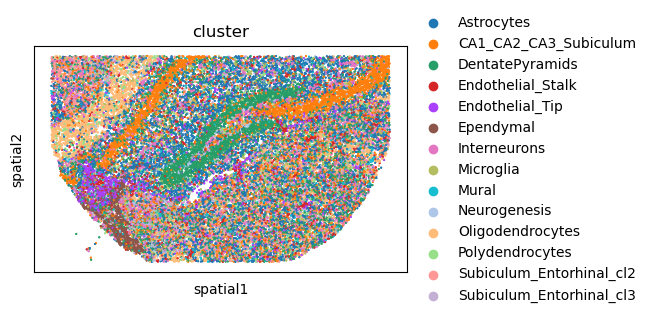

In [6]:
sq.pl.spatial_scatter(adata, color="cluster", size=1, shape=None)

In [7]:
sc.pp.filter_genes(adata, min_cells=50) ##如果基因在少于50个细胞中表达，就把它剔除掉。
print('After flitering: ', adata.shape)

#Normalization  归一和log adata数据。
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata) ##

After flitering:  (26146, 2764)


------Calculating spatial graph...
The graph contains 148464 edges, 26146 cells.
5.6783 neighbors per cell on average.


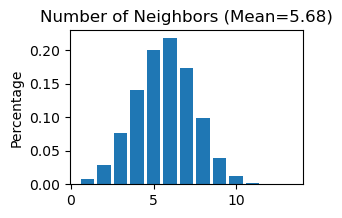

In [8]:
STAGATE_pyG.Cal_Spatial_Net(adata, rad_cutoff=30)
STAGATE_pyG.Stats_Spatial_Net(adata)

In [9]:
import time
start_time = time.time()
adata = STAGATE_pyG.train_STAGATE(adata,n_epochs=5000)
end_time = time.time()
adata.uns["Time"] = end_time-start_time

Size of Input:  (26146, 2764)


100%|██████████| 5000/5000 [03:17<00:00, 25.36it/s]


In [10]:
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.umap(adata)

In [11]:
adata.obs["cluster"]

TACTTTAGCGCAGT    CA1_CA2_CA3_Subiculum
TCGATATGGCACAA          DentatePyramids
ACGGATGTTCCGAT         Oligodendrocytes
TCTCATGGGTGGGA               Astrocytes
ACAGGGTTTATCGA    CA1_CA2_CA3_Subiculum
                          ...          
CTGGCTTTAGACCT    CA1_CA2_CA3_Subiculum
CGTCGGATGTAGGG                Microglia
CTTGATTAGGCAGG             Interneurons
GCGCTCAGTGCTCT             Interneurons
GAGATAACAGTTCC               Astrocytes
Name: cluster, Length: 26146, dtype: category
Categories (14, object): ['Astrocytes', 'CA1_CA2_CA3_Subiculum', 'DentatePyramids', 'Endothelial_Stalk', ..., 'Oligodendrocytes', 'Polydendrocytes', 'Subiculum_Entorhinal_cl2', 'Subiculum_Entorhinal_cl3']

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
num_cluster = 14 
kmeans = KMeans(n_clusters=num_cluster, algorithm = "lloyd", random_state=0).fit(adata.obsm['STAGATE'])
## Load KMeans lables in adata.obs
adata.obs["KMeans"] = adata.obs["cluster"]   
adata.obs["KMeans"] = kmeans.labels_    
obs_df = adata.obs.dropna() ##过滤掉缺失值的行，即当前分类值为Nan，就把该行过滤掉。
ARI = adjusted_rand_score(adata.obs["KMeans"].to_list(), adata.obs["cluster"].to_list()) ## ARI 是从 包sklearn.metrics.cluster中导入的衡量标准
print('Adjusted rand index = %.2f' %ARI)    
adata.uns["ARI"] = ARI

Adjusted rand index = 0.09


In [14]:
import pickle
file = open("./Results/Slide-seqV2_crop_STAGATE.pickle","wb")
pickle.dump(adata,file)
file.close()